In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("dataset/resize_borvo.csv")

# Konversi ke grid dictionary
grid = {}
for _, row in df.iterrows():
    grid[(int(row["i"]), int(row["j"]))] = {"H": row["H"], "W": row["W"]}

In [2]:
# Fungsi ambil tetangga 8 arah (termasuk diagonal)
def get_all_neighbors(pos):
    i, j = pos
    directions = [
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),           (0, 1),
        (1, -1), (1, 0), (1, 1)
    ]
    neighbors = [(i + di, j + dj) for di, dj in directions]
    return [n for n in neighbors if n in grid]

# Fungsi hitung skor W/E
def get_score(current_pos, neighbor_pos):
    H1 = grid[current_pos]["H"]
    H2 = grid[neighbor_pos]["H"]
    S = H1 - H2

    if S > 1.5:
        return -np.inf  # Tidak aman → skip
    
    E = 1 + 1 * abs(S)
    W = grid[neighbor_pos]["W"]
    return W / E

In [3]:
def hill_climbing_with_horizon(start, depth=3):
    if start not in grid:
        print(f"Titik {start} tidak ditemukan dalam dataset.")
        return [], []

    current = start
    path = [current]
    visited = set([start])
    
    energy = 500.0  # Energi awal rover
    energy_log = [energy]  # Simpan histori energi setelah setiap langkah

    def dfs(current_path, total_score, remaining_depth):
        current_node = current_path[-1]
        if remaining_depth == 0:
            return (total_score, current_path)

        best = (total_score, current_path)
        for neighbor in get_all_neighbors(current_node):
            if neighbor in current_path:
                continue
            score = get_score(current_node, neighbor)
            if score == -np.inf:
                continue
            result = dfs(current_path + [neighbor], total_score + score, remaining_depth - 1)
            if result[0] > best[0]:
                best = result
        return best

    while True:
        best_score = -np.inf
        best_path = None
        neighbors = get_all_neighbors(current)

        for neighbor in neighbors:
            if neighbor in visited:
                continue
            score = get_score(current, neighbor)
            if score == -np.inf:
                continue

            result_score, result_path = dfs([current, neighbor], score, depth - 1)

            if result_score > best_score:
                best_score = result_score
                best_path = result_path

        if best_path is None or best_path[1] in visited:
            break

        next_step = best_path[1]
        H1 = grid[current]["H"]
        H2 = grid[next_step]["H"]
        delta_energy = 1 + 1 * abs(H1 - H2)

        energy -= delta_energy
        if energy <= 0:
            print("Energi habis!")
            break

        current = next_step
        path.append(current)
        visited.add(current)
        energy_log.append(energy)

    return path, energy_log


In [4]:
# Titik uji coba
test_points = [
    (270, 324),
    (10, 251),
    (205, 457),
]

# Jalankan algoritma untuk semua titik uji
for idx, point in enumerate(test_points, 1):
    print(f"\n=== Titik {idx} - Start di {point} ===")
    path, energy_log = hill_climbing_with_horizon(point)
    print(f"Jumlah langkah: {len(path)}")
    print("Jalur, Skor, Energi, dan Kadar Air:")

    total_score = 0
    for i in range(1, len(path)):
        prev = path[i - 1]
        curr = path[i]
        score = get_score(prev, curr)
        total_score += score
        water_content = grid[curr]["W"]
        print(f"{prev} → {curr} | Skor: {score:.4f} | Sisa Energi: {energy_log[i]:.2f} | Kadar Air: {water_content:.2f}")
    
    print(f"Total Skor Jalur: {total_score:.4f}")
    print(f"Total Energi Tersisa: {energy_log[-1]:.2f}")




=== Titik 1 - Start di (270, 324) ===
Energi habis!
Jumlah langkah: 454
Jalur, Skor, Energi, dan Kadar Air:
(270, 324) → (270, 323) | Skor: 53.6125 | Sisa Energi: 498.70 | Kadar Air: 69.58
(270, 323) → (269, 322) | Skor: 67.4936 | Sisa Energi: 497.67 | Kadar Air: 69.70
(269, 322) → (270, 321) | Skor: 67.8279 | Sisa Energi: 496.64 | Kadar Air: 69.90
(270, 321) → (271, 320) | Skor: 67.0656 | Sisa Energi: 495.60 | Kadar Air: 69.91
(271, 320) → (270, 319) | Skor: 69.2541 | Sisa Energi: 494.58 | Kadar Air: 70.09
(270, 319) → (269, 319) | Skor: 69.9312 | Sisa Energi: 493.58 | Kadar Air: 70.12
(269, 319) → (269, 320) | Skor: 62.4105 | Sisa Energi: 492.46 | Kadar Air: 70.28
(269, 320) → (269, 321) | Skor: 65.2115 | Sisa Energi: 491.38 | Kadar Air: 70.32
(269, 321) → (270, 322) | Skor: 63.9632 | Sisa Energi: 490.28 | Kadar Air: 69.88
(270, 322) → (269, 323) | Skor: 62.6705 | Sisa Energi: 489.17 | Kadar Air: 70.05
(269, 323) → (269, 324) | Skor: 69.2473 | Sisa Energi: 488.16 | Kadar Air: 69.91


Energi habis!


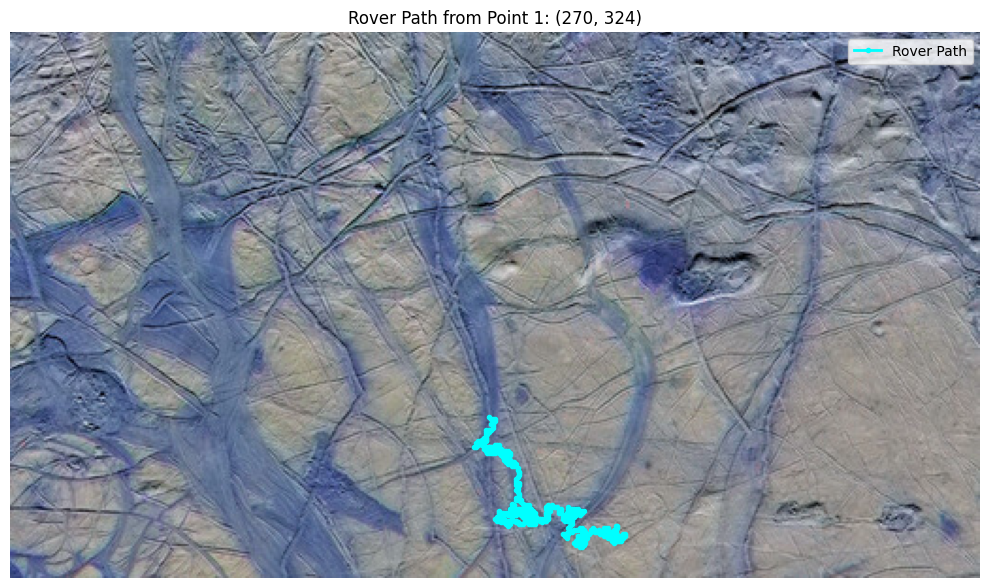

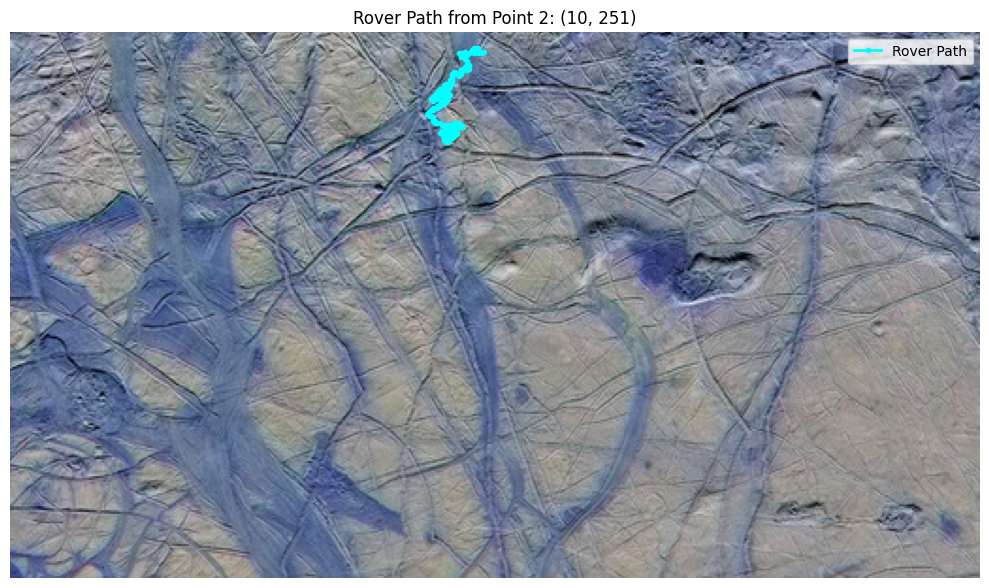

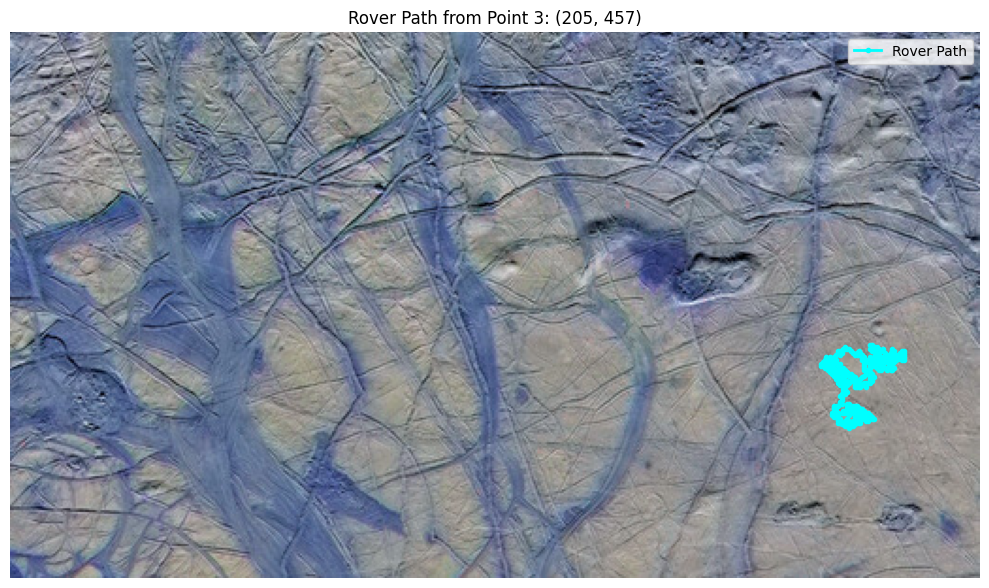

In [5]:
import matplotlib.pyplot as plt
import cv2

# Muat gambar height map dan konversi ke grayscale
img = cv2.imread("europa_map/raw/resize_borvo_mensa.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
H_map = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=5)  # Representasi elevasi sederhana

# Visualisasi jalur untuk semua titik uji coba
for idx, point in enumerate(test_points, 1):
    path, _ = hill_climbing_with_horizon(point, depth=3)
    path_x = [j for i, j in path]  # j = x-axis
    path_y = [i for i, j in path]  # i = y-axis

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.plot(path_x, path_y, color="cyan", marker="o", linewidth=2, markersize=3, label="Rover Path")
    plt.title(f"Rover Path from Point {idx}: {point}")
    plt.legend()
    plt.axis("off")
    plt.tight_layout()
    plt.show()
